# Solving the SWE using NN

In [1]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import time

## Load data

In [355]:
s = 2

# Initialize an empty list to store the loaded data
t_mesh_all = []
h_all = []

# Loop to load the .mat files from data_sigma_no1.mat to data_sigma_no10.mat
for i in range(1, s):
    # Construct the filename dynamically
    filename = f'dataFNO/data_sigma_no1mu_no{i}.mat'
    
    # Load the .mat file
    mat_data = scipy.io.loadmat(filename)
    
    # Print the name of the loaded file
    print(f'Loaded: {filename}')
    
    # Store the loaded data in the list
    x_mesh = mat_data['x'].flatten()
    t_mesh_all.append(mat_data['time_all'])
    h_all.append(np.real(mat_data['h_all'][1:,:]))

# Now all_data contains the loaded data from all files


Loaded: dataFNO/data_sigma_no1mu_no1.mat


In [356]:
if 0:
    # Load a single .mat file
    #filename = 'dataFNO/data_sigma_no1.mat'
    #mat_data = scipy.io.loadmat(filename)

    # Print the keys of the loaded data
    print(mat_data.keys())

    # Extract the necessary data (x and h_all) from the loaded data
    x_mesh = mat_data['x'].flatten()
    h_all = mat_data['h_all']
    t_mesh = mat_data['time_all'].flatten()

    print(h_all.shape)
    sigma = mat_data['sigma'][0,0]

    print('sigma:', sigma)


In [357]:
if 0:
    # Plot the initial condition
    plt.figure()
    plt.plot(x_mesh, h_all[0,:])
    plt.xlabel('Distance x (m)')
    plt.ylabel('Water height h (m)')
    plt.title('Initial condition for the water height h (m)')
    plt.grid()

    if 0:
        plt.savefig('plots/NN_initial_1D.pdf', format='pdf')

    plt.show()


In [358]:
h_all[0].shape
#t_mesh_all[0].shape

(730, 200)

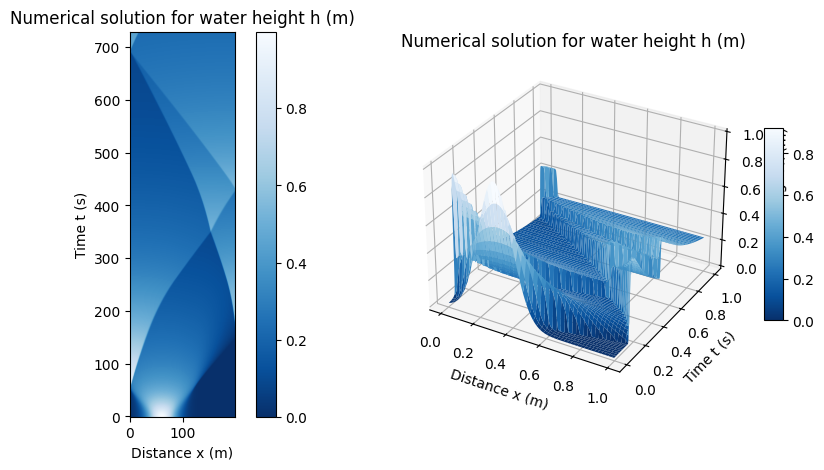

In [360]:
save = 0

cmap = 'Blues_r'

idx = 0

# Plot the data in x,t space
fig = plt.figure(figsize=(12, 5))
  
ax0 = fig.add_subplot(121)
#img = ax0.imshow(h_all[idx], extent=[x_mesh[0], x_mesh[-1], t_mesh_all[idx][-1], t_mesh_all[idx][0]], aspect='auto', cmap=cmap)
img = ax0.imshow(h_all[idx], cmap=cmap)
plt.colorbar(img, ax=ax0)
ax0.set_title('Numerical solution for water height h (m)')
ax0.set_xlabel('Distance x (m)')
ax0.set_ylabel('Time t (s)')
ax0.invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x_mesh, t_mesh_all[idx])
ax1 = fig.add_subplot(122, projection='3d')
surf1 = ax1.plot_surface(X, T, h_all[idx], cmap=cmap)
ax1.set_title('Numerical solution for water height h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Time t (s)')
ax1.set_zlabel('Water height h (m)')
fig.colorbar(surf1, ax=ax1, shrink = 0.5, aspect=10)

if save:
    plt.savefig('plots/NN_initial.pdf', format='pdf')

plt.show()


### Function: prepare_data

In [178]:
def prepare_data(h_all, p_train, p_val):

    timesteps, _ = h_all.shape

    # Input a
    a = h_all[:-1]

    # Target u
    u = h_all[1:]

    # Split data into training, validation and test sets
    n_train = int(p_train * timesteps)
    n_val = int(p_val * timesteps)
    n_test = timesteps - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    # Define input and target training sets, validation sets and test sets
    train_x = torch.tensor(a[:n_train], dtype=torch.float32)
    train_y = torch.tensor(u[:n_train], dtype=torch.float32)

    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)

    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)

    x = torch.tensor(a, dtype=torch.float32)
    y = torch.tensor(u, dtype=torch.float32)

    #print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y


In [238]:
def prepare_combined_data(h_all, p_train_last=0.7, p_val_last=0.15):
    # Initialize lists for training, validation, and test data
    train_x_list, train_y_list = [], []
    val_x_list, val_y_list = [], []
    test_x_list, test_y_list = [], []
    x_list, y_list = [], []

    # Process each case in h_all
    for i, h in enumerate(h_all):
        h_array = np.array(h)  # Convert to NumPy array if necessary
        if i < len(h_all) - 1:  # For the first slices, use 100% training
            n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_array, 1.0, 0.0)
        else:  # For the last case, use specified split proportions
            n_train, n_val, n_test, x, y, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data(h_array, p_train_last, p_val_last)

        # Append results to lists
        train_x_list.append(train_x)
        train_y_list.append(train_y)
        if val_x.shape[0] > 0:  # Only add validation data if it exists
            val_x_list.append(val_x)
            val_y_list.append(val_y)
        if test_x.shape[0] > 0:  # Only add test data if it exists
            test_x_list.append(test_x)
            test_y_list.append(test_y)
        
    # Collect the x and y data for the last case
    x_list.append(x)
    y_list.append(y)
            
    # Concatenate lists into tensors
    train_x_combined = torch.cat(train_x_list, dim=0)
    train_y_combined = torch.cat(train_y_list, dim=0)
    val_x_combined = torch.cat(val_x_list, dim=0) if val_x_list else torch.empty(0)
    val_y_combined = torch.cat(val_y_list, dim=0) if val_y_list else torch.empty(0)
    test_x_combined = torch.cat(test_x_list, dim=0) if test_x_list else torch.empty(0)
    test_y_combined = torch.cat(test_y_list, dim=0) if test_y_list else torch.empty(0)
    x_combined = torch.cat(x_list, dim=0)
    y_combined = torch.cat(y_list, dim=0)

    return train_x_combined, train_y_combined, val_x_combined, val_y_combined, test_x_combined, test_y_combined, x_combined, y_combined

In [41]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Solve the SWE using NN

### (i) FNN

In [277]:
in_features = 200
hidden1 = 128
hidden2 = 128
hidden3 = 64
out_features = 200

model = nn.Sequential(
    nn.Linear(in_features, hidden1),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden1, hidden2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(hidden2, hidden3),
    nn.Linear(hidden3, out_features),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=200, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): Linear(in_features=64, out_features=200, bias=True)
  (8): Sigmoid()
)


In [278]:
train_x, train_y, val_x, val_y, test_x, test_y, x, y = prepare_combined_data(h_all, p_train_last=0.6, p_val_last=0.2)

print("Training data:", train_x.shape, train_y.shape)
print("Validation data:", val_x.shape, val_y.shape)
print("Test data:", test_x.shape, test_y.shape)

dataset_train = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(val_x, val_y)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)

n_train = 730, n_val = 0, n_test = 0
n_train = 711, n_val = 0, n_test = 0
n_train = 694, n_val = 0, n_test = 0
n_train = 678, n_val = 0, n_test = 0
n_train = 663, n_val = 0, n_test = 0
n_train = 390, n_val = 130, n_test = 131
Training data: torch.Size([3861, 200]) torch.Size([3861, 200])
Validation data: torch.Size([130, 200]) torch.Size([130, 200])
Test data: torch.Size([130, 200]) torch.Size([130, 200])


In [279]:
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train = []
loss_val = []

# Time training
start_time = time.time()

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train() # Set model to training mode
    epoch_train_loss = 0 # Initialize epoch loss

    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0) # Accumulate loss
    

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0 # Initialize epoch loss

    with torch.no_grad(): # Deactivate autograd
            for batch_X, batch_y in val_loader:
                # Forward pass
                val_predictions = model(batch_X)
                val_loss = loss_fn(val_predictions, batch_y)

                # Accumulate loss
                epoch_val_loss += loss.item() * batch_X.size(0)
        
    # Average losses
    epoch_train_loss /= len(dataset_train)
    epoch_val_loss /= len(dataset_val)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print loss every 10 epochs
    if epoch % 10 == 9:
        print(f"Epoch {epoch+1}/{n_epochs}, Training loss: {loss.item():.7f}, Validation loss: {val_loss.item():.7f}")

# Time training
end_time = time.time()
print(f"Training time: {end_time - start_time}s")


Epoch 10/100, Training loss: 0.0025701, Validation loss: 0.0012066
Epoch 20/100, Training loss: 0.0017772, Validation loss: 0.0008949
Epoch 30/100, Training loss: 0.0013453, Validation loss: 0.0007550
Epoch 40/100, Training loss: 0.0011127, Validation loss: 0.0010022
Epoch 50/100, Training loss: 0.0012032, Validation loss: 0.0007741
Epoch 60/100, Training loss: 0.0013722, Validation loss: 0.0010855
Epoch 70/100, Training loss: 0.0007699, Validation loss: 0.0006684
Epoch 80/100, Training loss: 0.0012822, Validation loss: 0.0007341
Epoch 90/100, Training loss: 0.0009148, Validation loss: 0.0006485
Epoch 100/100, Training loss: 0.0008780, Validation loss: 0.0007198
Training time: 43.531620502471924s


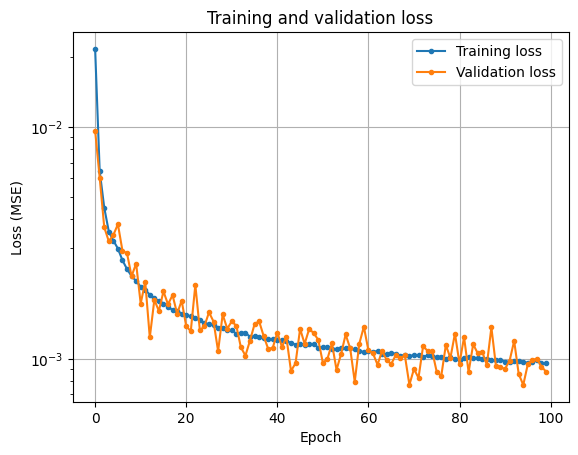

In [280]:
# Plot loss
plt.semilogy(loss_train, '.-', label='Training loss')
plt.semilogy(loss_val, '.-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()


In [281]:
# Test loss
with torch.no_grad():
    test_loss = loss_fn(model(test_x), test_y)
    print(f"Test loss: {test_loss.item():.2e}")


Test loss: 4.83e-04


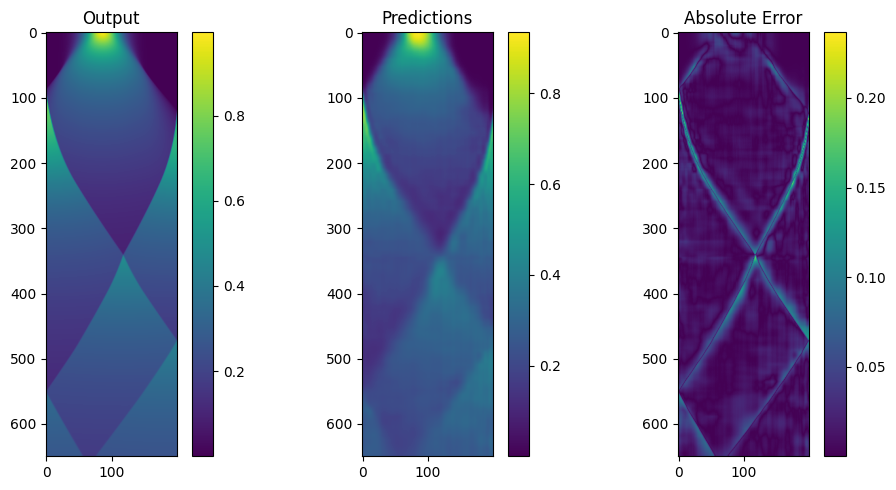

In [282]:
# Compute predictions
model.eval()
predictions = model(x)

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(y.detach().numpy())
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 2)
plt.imshow(predictions.detach().numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(y.detach().numpy() - predictions.detach().numpy()))
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()

plt.show()


### (ii) RNN Flowmap

In [361]:
save = 0

In [362]:
# Define model
class RNNFlowmap(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(RNNFlowmap, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last hidden state for prediction
        return out
    
input_size = 200
hidden_size = 128
output_size = 200
batch_size = 32

# Instantiate the model
model = RNNFlowmap(input_size, hidden_size, output_size)
print(model)

RNNFlowmap(
  (rnn): RNN(200, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=200, bias=True)
  )
)


In [370]:
train_x, train_y, val_x, val_y, test_x, test_y, x, y = prepare_combined_data(h_all, p_train_last=0.7, p_val_last=0.2)

print("Training data:", train_x.shape, train_y.shape)
print("Validation data:", val_x.shape, val_y.shape)
print("Test data:", test_x.shape, test_y.shape)

dataset_train = torch.utils.data.TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset_train, batch_size, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(val_x, val_y)
val_loader = DataLoader(dataset_val, batch_size, shuffle=True)

n_train = 510, n_val = 146, n_test = 74
Training data: torch.Size([510, 200]) torch.Size([510, 200])
Validation data: torch.Size([146, 200]) torch.Size([146, 200])
Test data: torch.Size([73, 200]) torch.Size([73, 200])


In [371]:
# Prepare data in sequences
def prepare_data_sequences(x, y, seq_length):
    timesteps, spatial_steps = x.shape

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, spatial_steps))
    y_seq = torch.zeros((n_sequences, spatial_steps))

    for i in range(n_sequences):
        x_seq[i] = x[i:i + seq_length]
        y_seq[i] = y[i + seq_length]
    
    return x_seq, y_seq

In [372]:
seq_length = 10

X_input, X_output = prepare_data_sequences(train_x, train_y, seq_length)
print(X_input.shape, X_output.shape)
X_input_val, X_output_val = prepare_data_sequences(val_x, val_y, seq_length)

batch_size = 32

# Create a dataloader for training and validation data
train_dataset = torch.utils.data.TensorDataset(X_input, X_output)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_input_val, X_output_val)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)


torch.Size([500, 10, 200]) torch.Size([500, 200])


In [373]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_train = []
loss_val = []

# Time training
start_time = time.time()

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = criterion(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Validation loss
    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation for validation
        for val_X, val_y in val_loader:
            val_predictions = model(val_X)
            val_loss = criterion(val_predictions, val_y)
            epoch_val_loss += val_loss.item() * val_X.size(0)

    # Average losses
    epoch_train_loss /= len(train_dataset)
    epoch_val_loss /= len(val_dataset)

    # Append losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print epoch loss
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Training loss: {epoch_train_loss:.6f}, Validation loss: {epoch_val_loss:.6f}")

# Time training
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f}s")

Epoch 10/100, Training loss: 0.000370, Validation loss: 0.006313
Epoch 20/100, Training loss: 0.000382, Validation loss: 0.006255
Epoch 30/100, Training loss: 0.000295, Validation loss: 0.006658
Epoch 40/100, Training loss: 0.000273, Validation loss: 0.006169
Epoch 50/100, Training loss: 0.000266, Validation loss: 0.006422
Epoch 60/100, Training loss: 0.000234, Validation loss: 0.006632
Epoch 70/100, Training loss: 0.000270, Validation loss: 0.006487
Epoch 80/100, Training loss: 0.001533, Validation loss: 0.005486
Epoch 90/100, Training loss: 0.000925, Validation loss: 0.005836
Epoch 100/100, Training loss: 0.000764, Validation loss: 0.005466
Training time: 31.01s


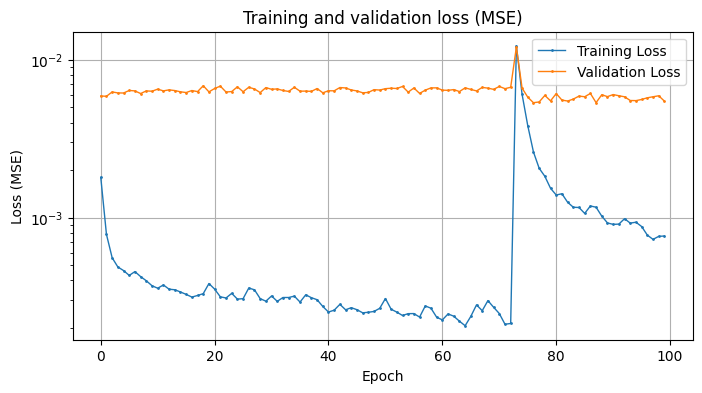

In [374]:
# Plot loss
plt.figure(figsize=(8, 4))
plt.semilogy(loss_train, '.-', label='Training Loss', linewidth=1, markersize=2)
plt.semilogy(loss_val, '.-', label='Validation Loss', linewidth=1, markersize=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and validation loss (MSE)')
plt.legend()
plt.grid()

if save:
    plt.savefig('plots/NN_loss_train_val.pdf', format='pdf')

plt.show()

In [375]:
X_all, Y_all = prepare_data_sequences(x, y, seq_length=10)

# Predictions
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation 
    predictions = model(X_all)  # Full dataset
    test_loss = criterion(predictions, Y_all)
    print(f"Loss: {test_loss.item():.2e}")

Loss: 1.97e-03


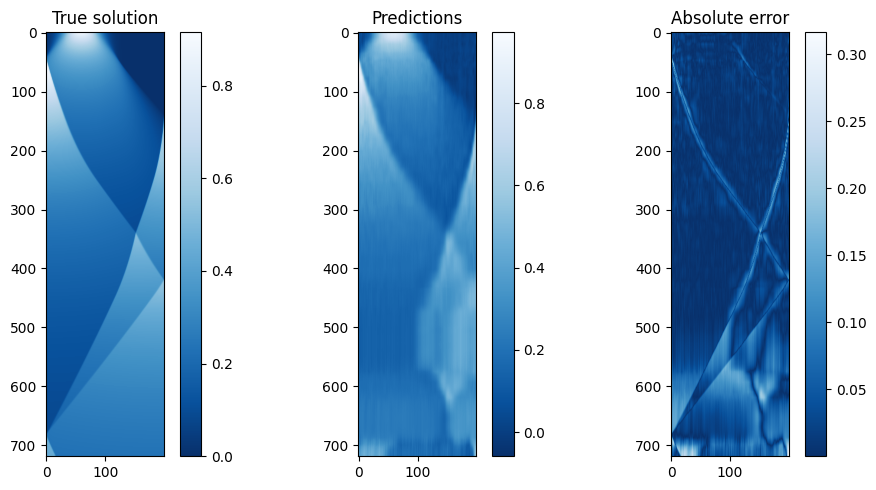

In [376]:
# Plot the output, predictions and absolute error
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y_all.numpy(), cmap=cmap)
plt.colorbar()
plt.title('True solution')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy(), cmap=cmap)
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(Y_all.numpy() - predictions.numpy()), cmap=cmap)
plt.colorbar()
plt.title('Absolute error')

plt.tight_layout()

plt.show()

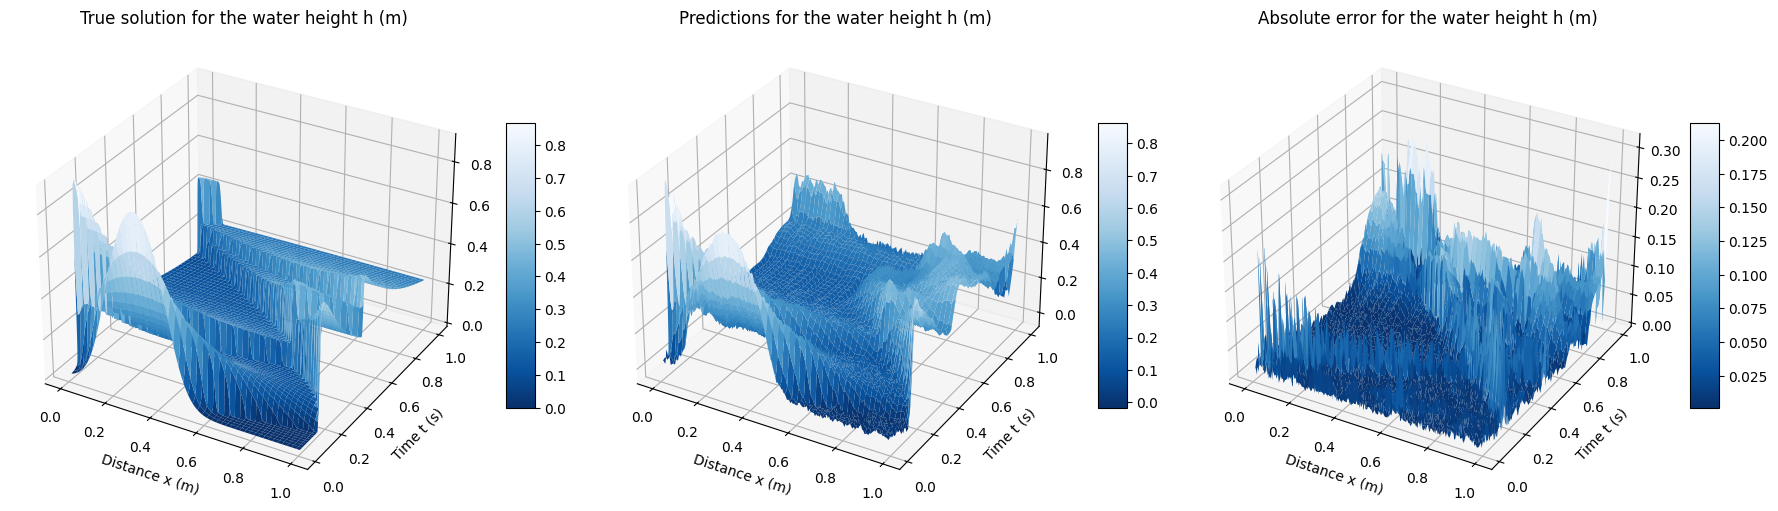

In [377]:
# Prepare grid
X, T = np.meshgrid(x_mesh, t_mesh_all[-1][seq_length+1:])

# Plot the output, predictions and absolute error
fig = plt.figure(figsize=(18, 6))

cmap = 'Blues_r'

# Plot in 3d
ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, T, Y_all.numpy(), cmap=cmap)
ax1.set_title('True solution for the water height h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Time t (s)')
fig.colorbar(surf1, ax=ax1, shrink = 0.5, aspect=10)

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, T, predictions.numpy(), cmap=cmap)
ax2.set_title('Predictions for the water height h (m)')
ax2.set_xlabel('Distance x (m)')
ax2.set_ylabel('Time t (s)')
fig.colorbar(surf2, ax=ax2, shrink = 0.5, aspect=10)

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, T, np.abs(Y_all.numpy() - predictions.numpy()), cmap=cmap)
ax3.set_title('Absolute error for the water height h (m)')
ax3.set_xlabel('Distance x (m)')
ax3.set_ylabel('Time t (s)')
fig.colorbar(surf3, ax=ax3, shrink = 0.5, aspect=10)

plt.tight_layout()

if save:
    plt.savefig('plots/NN_predictions.pdf', format='pdf')

plt.show()

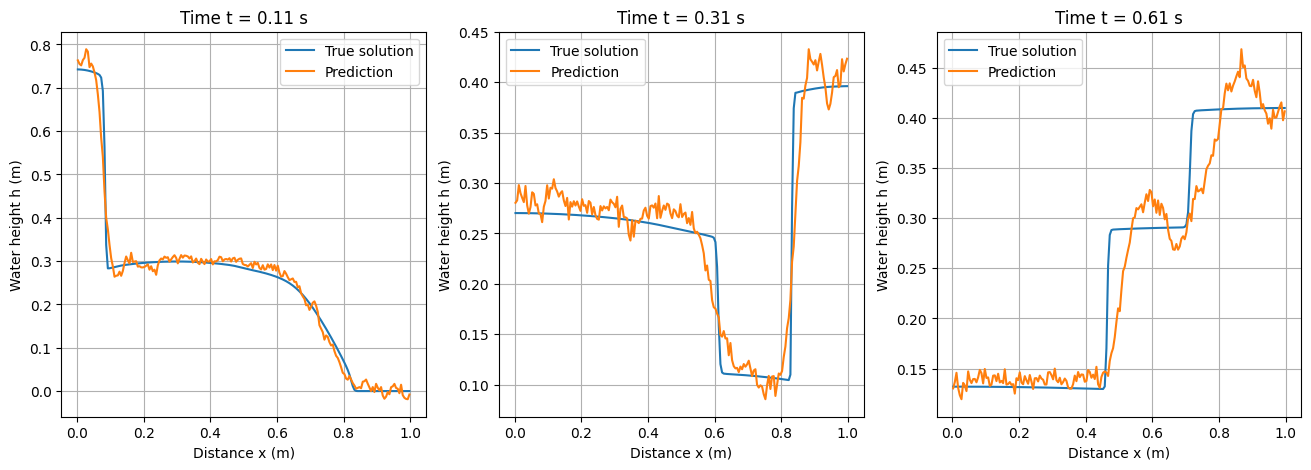

In [378]:
# Plot for some given time steps
indices = [100, 300, 500]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

for i, idx in enumerate(indices):
    ax = axes[i]
    ax.plot(x_mesh, Y_all[idx].numpy(), label='True solution')
    ax.plot(x_mesh, predictions[idx].numpy(), label='Prediction')
    ax.set_title(f"Time t = {t_mesh[idx]:.2f} s")
    ax.set_xlabel('Distance x (m)')
    ax.set_ylabel('Water height h (m)')
    ax.grid()
    ax.legend()

if save:
    plt.savefig('plots/NN_predictions_time_steps.pdf', format='pdf')

plt.show()

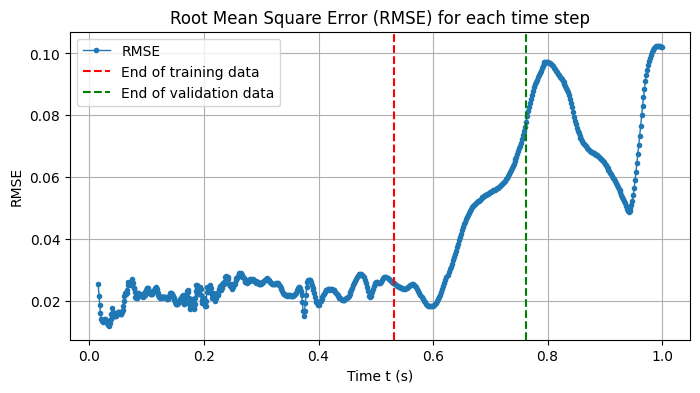

In [379]:
# Plot the RMSE for each time step
rmse = torch.sqrt(torch.mean((Y_all - predictions)**2, dim=1))

plt.figure(figsize=(8, 4))
plt.plot(t_mesh_all[-1][seq_length+1:], rmse.numpy(),'.-', label='RMSE', linewidth=1)
plt.xlabel('Time t (s)')
plt.ylabel('RMSE')
plt.title('Root Mean Square Error (RMSE) for each time step')
plt.grid()
plt.axvline(x=t_mesh[n_train], color='r', linestyle='--', label='End of training data')
plt.axvline(x=t_mesh[n_train+n_val], color='g', linestyle='--', label='End of validation data')
plt.legend()

if save:
    plt.savefig('plots/NN_RMSE.pdf', format='pdf')

plt.show()


### (iii) LSTM (Long short-term memory)

In [380]:
# LSTM class neural network
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 100
hidden_size = 128
output_size = 100

# Define model
model = LSTM(input_size, hidden_size, output_size)
print(model)

LSTM(
  (lstm): LSTM(100, 128, num_layers=4, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=100, bias=True)
  )
)


In [381]:
# Define sequence length
sequence_length = 5
num_sequences = 243 - sequence_length
X = h_train.copy()
batch_size = 32

# Create input-output pairs
X_input = []
X_output = []

for i in range(num_sequences):
    X_input.append(X[i:i+sequence_length])    # Sequence of length 5
    X_output.append(X[i+sequence_length])    # Next time step

X_input = np.array(X_input)  # Shape: (num_sequences, sequence_length, 100)
X_output = np.array(X_output)  # Shape: (num_sequences, 100)

X_input_tensor = torch.tensor(X_input, dtype=torch.float32)
X_output_tensor = torch.tensor(X_output, dtype=torch.float32)

# Create a DataLoader
batch_size = 32
dataset = torch.utils.data.TensorDataset(X_input_tensor, X_output_tensor)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


NameError: name 'h_train' is not defined

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []

# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0  # Track loss for the epoch
    
    for batch_X, batch_y in data_loader:
        # Forward pass
        predictions = model(batch_X)  # Shape: (batch_size, output_size)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item() * batch_X.size(0)  # Multiply by batch size for total loss

    # Average epoch loss
    epoch_loss /= len(dataset)
    losses.append(epoch_loss)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.6f}")

Epoch 10/10, Loss: 0.014578


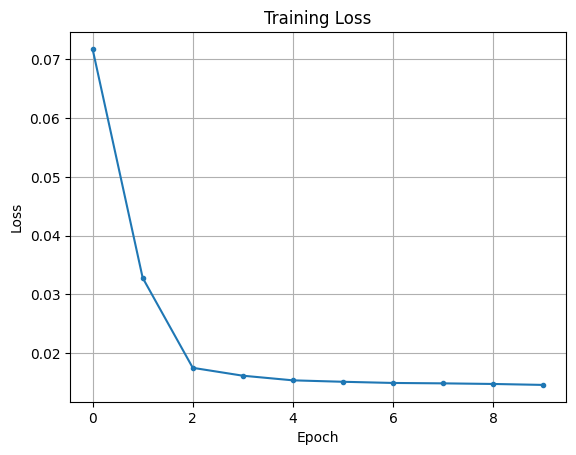

In [ ]:
# Plot loss
plt.plot(losses, '.-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

Test Loss: 0.014357


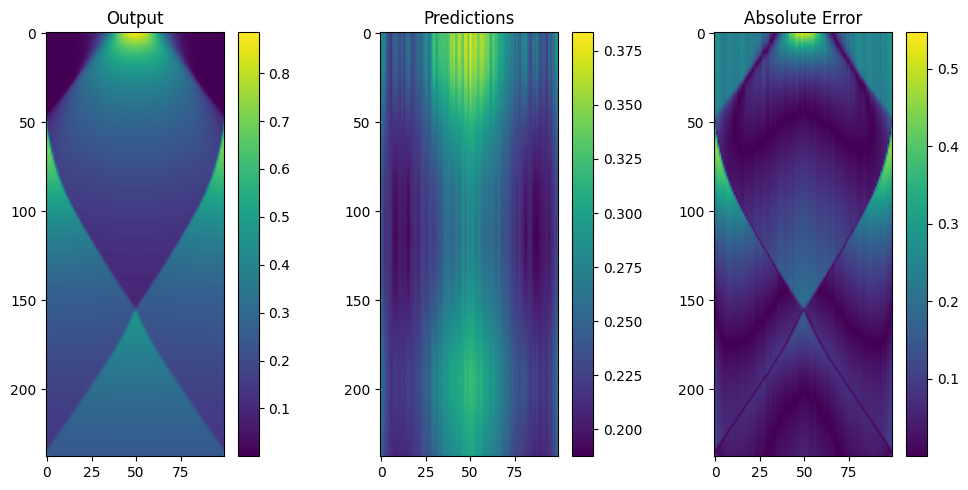

In [ ]:
model.eval()  # Set to evaluation mode
with torch.no_grad():  # Disable gradient computation
    predictions = model(X_input_tensor)  # Full dataset
    test_loss = loss_fn(predictions, X_output_tensor)
    print(f"Test Loss: {test_loss.item():.6f}")

# Plot the input, output, and predictions
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_output)
plt.colorbar()
plt.title('Output')

plt.subplot(1, 3, 2)
plt.imshow(predictions.numpy())
plt.colorbar()
plt.title('Predictions')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(X_output - predictions.numpy()))
plt.colorbar()
plt.title('Absolute Error')

plt.tight_layout()
plt.show()
